Project_house_price

In [3]:
import numpy as np
import pandas as pd
import datetime
import time

from sklearn import preprocessing
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, LassoCV,LassoLarsCV, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import skew

from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# EDA

In [28]:
#plt.figure(figsize=(10,8))
#sns.boxplot(train.YearBuilt, train.SalePrice)

sns.swarmplot(x="YearBuilt", y="SalePrice", data=train)
plt.show()

<IPython.core.display.Javascript object>


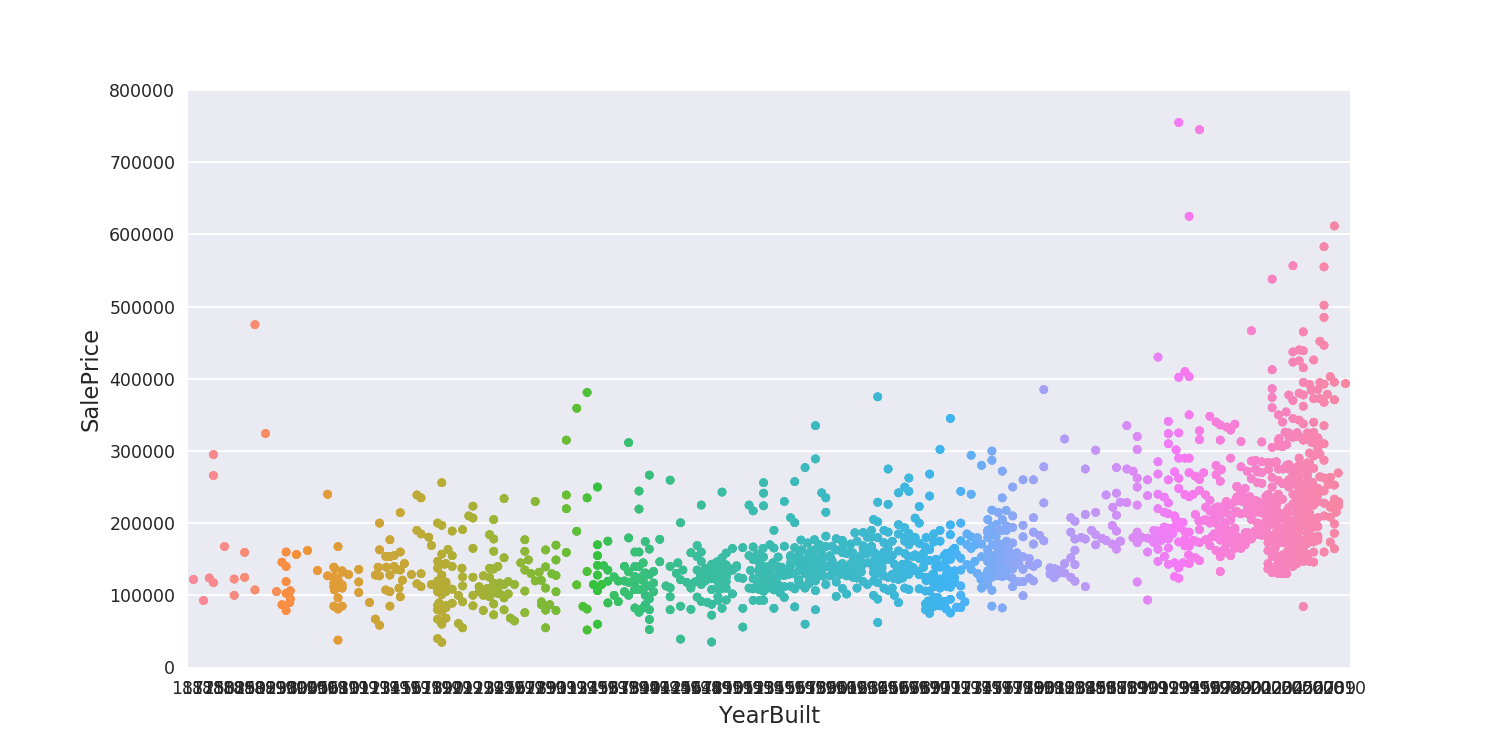

(0, 800000)

In [10]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

### manual? 에서 5가지 값은 제외 해주고 보는것이 좋기 때문에 제외해 주도록 하자


In [12]:
train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index,inplace=True)


## 데이터 결합

 

pd.concat(objs,  # Series, DataFrame, Panel object

             axis=0,  # 0: 위+아래로 합치기, 1: 왼쪽+오른쪽으로 합치기

             join='outer', # 'outer': 합집합(union), 'inner': 교집합(intersection)

             join_axes=None, # axis=1 일 경우 특정 DataFrame의 index를 그대로 이용하려면 입력

             ignore_index=False,  # False: 기존 index 유지, True: 기존 index 무시
             keys=None, # 계층적 index 사용하려면 keys 튜플 입력

             levels=None,

             names=None, # index의 이름 부여하려면 names 튜플 입력

             verify_integrity=False, # True: index 중복 확인
             copy=True) # 복사

In [16]:
all_data = pd.concat([train,test], ignore_index=True)

In [17]:
all_data.drop(['Id'],axis=1, inplace=True)
all_data.shape

(2917, 80)

# Data Cleaning

# missing data

In [18]:
not_null_all = all_data.isnull().sum()
not_null_all[not_null_all>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

## 비어있는 값들에 값을 채워주기 위해서 데이터의 값을 확인해봄

In [21]:
all_data.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

# Featuring

In [ ]:
# data loading 
train = pd.read_csv("./train.csv") 
test = pd.read_csv("./test.csv") 

In [ ]:
def create_submission(prediction,score):
       
    
    sub_file = 'submission_'+str(score)+'.csv'
    #sub_file = 'prediction_training.csv'
    #print ('Creating submission: ', sub_file)
    pd.DataFrame({'Id': test['Id'].values, 'SalePrice': prediction}).to_csv(sub_file, index=False)


In [ ]:
def data_preprocess(train,test):
#     outlier_idx = [4,11,13,20,46,66,70,167,178,185,199, 224,261, 
#                    309,313,318, 349,412,423,440,454,477,478,523,
#                    540, 581,588,595,654,688,691,774,798,875,898,
#                    926,970,987,1027,1109,1169,1182,1239,1256,
#                    1298,1324,1353,1359,1405,1442,1447]
    
#     train.drop(train.index[outlier_idx],inplace=True)
    
    # train + test data
    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                          test.loc[:,'MSSubClass':'SaleCondition']))
    # delete some feature
#     to_delete = ['']
        
    all_data = all_data.drop(to_delete,axis=1)

    
    train["SalePrice"] = np.log1p(train["SalePrice"])
   
    return X_train,X_test,y